In [1]:
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as hc
import matplotlib.pyplot as plt
import scipy.spatial.distance as ssd

from scipy.io import loadmat
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelBinarizer

# MAT 388E HW3

## Q1

This is going to be an image classification problem. For this problem we are going to use [the corrected Indian Pines Dataset](https://www.ehu.eus/ccwintco/index.php?title=Hyperspectral_Remote_Sensing_Scenes#Indian_Pines).

1. Download the data (both the corrected dataset and the ground-truth dataset) into a subdirectory called `data`, and ingest it as I did in [Lecture 8](https://github.com/kaygun/2022-Fall-388E/blob/main/lecture-8.ipynb).
2. Instead of using a categorical target variable with 17 classes, from the ground-truth data you ingested create 17 binary classifiers using scikit-learn's [`LabelBinarizer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html).

For the steps 3,4, and 5 below write an appropriate function that takes a model type ('LR','SVM', or 'KNN'), the independent variable (the dataset you ingested above) and binary target variable and returns the accuracy score of a properly constructed model given by a 10-fold cross-validation. Use scikitlearn's [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html) routines. Record your results from Steps 2,3 and 4 in a pandas data frame.  

3. Construct a logistic regression model for each of the 17 class, and evaluate them using a 10-fold cross-validation. 
4. Construct an SVM model for each of the 17 class, and evaluate them using a 10-fold cross-validation. 
5. Construct a KNN model for each of the 17 class and evaluate them using a 10-fold cross-validation. You must determine what would be an appropriate K-value for each class separately, or you may decide to use a single K-value.
6. Display and analyze your cross-validation results in a table. What is the best model overall? What is the best model for each class? 

In [ ]:
pine = loadmat('./data/Indian_pines_corrected.mat')['indian_pines_corrected']
pine_gt = loadmat('./data/Indian_pines_gt.mat')['indian_pines_gt']

In [ ]:
pine

In [ ]:
pine_gt

In [ ]:
X = pine.reshape((145*145,200))
y = pine_gt.reshape(145*145)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3)

In [ ]:
def experiment(X, y, N=1500, solver='lbfgs', multi='auto'):
    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.75)
    model = LogisticRegression(max_iter=N, solver=solver)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return confusion_matrix(y_test,y_pred)

In [ ]:
X = pine.reshape((145*145, 200))
encoder = LabelBinarizer()
ys = encoder.fit_transform(y)
experiment(X, ys[:,0])

In [ ]:
def experiment(X_train, X_test, y_train, y_test, N=1500, kernel='rbf', C=1.0):
    model = SVC(max_iter=N,kernel=kernel)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return confusion_matrix(y_test,y_pred)

In [ ]:
X = pine.reshape((145*145,200))
encoder = LabelBinarizer()
ys = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, ys, train_size=0.75)
experiment(X_train, X_test, y_train[:,0], y_test[:,0])

In [ ]:
df = pd.DataFrame(pine_gt)
df

In [ ]:
#KNN over-under fitting
train_accuracies = {}
test_accuracies = {}
neighbors = np.arange(1, 20)
for neighbor in neighbors:
    knn = KNeighborsClassifier(n_neighbors = neighbor)
    knn.fit(X_train, y_train)
    train_accuracies[neighbor] = knn.score(X_train, y_train)
    test_accuracies[neighbor] = knn.score(X_test, y_test)

In [ ]:
plt.figure(figsize=(8,6))
plt.title("KNN: Varying Number of Neighbors")
plt.plot(neighbors, train_accuracies.values(), label="training accuracy")
plt.plot(neighbors, test_accuracies.values(), label= "testing accuracy")
plt.legend()
plt.xlabel("number of neighbors")
plt.ylabel("accuracy")
plt.show

optimal number of neighbors for our model
using more folds is more computationally expensive

In [ ]:
kf = KFold(n_splits = 10, shuffle= True, random_state = 42)
reg = LogisticRegression()
cv_results = cross_val_score(reg, X, y, cv =kf)
# the length of the array is the number of folds utilized
print(cv_results)
print(np.mean(cv_results), np.std(cv_results))
print(np.quantile(cv_results, [0.025, 0.975]))

In [ ]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3) # çünkü 3 species var
model.fit(samples)

labels = model.predict(samples)

 Örneğin, KNN sınıflandırma algoritmasında k değerinin ne olacağına modeli tasarlayan kişi karar vermektedir. Benzer şekilde SVM algoritmasında hangi kernel fonksiyonunun kullanılacağına da tasarımcı karar verir. 

  Ne olması gerektiği, modeli tasarlayan kişiye bırakılmış, probleme, veri setine göre değişiklik gösteren parametreler hiper-parametre (hyperparameters) olarak adlandırılmaktadır.

## Q2

For this question, we are going to analyze some [NBA datasets](https://sports-statistics.com/sports-data/nba-basketball-datasets-csv-files/). Specifically, we look at the season 2018-2019.

In [2]:
NBA = pd.read_csv('https://sports-statistics.com/database/basketball-data/nba/2018-19_pbp.csv')
NBA.columns

Index(['Unnamed: 0', 'EVENTMSGACTIONTYPE', 'EVENTMSGTYPE', 'EVENTNUM',
       'GAME_ID', 'HOMEDESCRIPTION', 'NEUTRALDESCRIPTION', 'PCTIMESTRING',
       'PERIOD', 'PERSON1TYPE', 'PERSON2TYPE', 'PERSON3TYPE', 'PLAYER1_ID',
       'PLAYER1_NAME', 'PLAYER1_TEAM_ABBREVIATION', 'PLAYER1_TEAM_CITY',
       'PLAYER1_TEAM_ID', 'PLAYER1_TEAM_NICKNAME', 'PLAYER2_ID',
       'PLAYER2_NAME', 'PLAYER2_TEAM_ABBREVIATION', 'PLAYER2_TEAM_CITY',
       'PLAYER2_TEAM_ID', 'PLAYER2_TEAM_NICKNAME', 'PLAYER3_ID',
       'PLAYER3_NAME', 'PLAYER3_TEAM_ABBREVIATION', 'PLAYER3_TEAM_CITY',
       'PLAYER3_TEAM_ID', 'PLAYER3_TEAM_NICKNAME', 'SCORE', 'SCOREMARGIN',
       'VISITORDESCRIPTION', 'WCTIMESTRING'],
      dtype='object')

1. Using the columns `PLAYER1_TEAM_ABBREVIATION`, `PLAYER2_TEAM_ABBREVIATION`, `PLAYER3_TEAM_ABBREVIATION` construct a 30x30 matrix that has the total number of interactions the teams had with each other during the season.
2. Using the matrix you constructed in the previous step, construct a hiearchical clustering model and split the NBA teams into 2 clusters.
3. NBA Teams are split into 2 Leagues: [The Eastern Conference](https://en.wikipedia.org/wiki/Eastern_Conference_(NBA)) and [The Western Conference](https://en.wikipedia.org/wiki/Western_Conference_(NBA)). What is the relationships of the clusters with these leagues. Explain.
4. Using the columns `PLAYER1_NAME`, `PLAYER2_NAME`, `PLAYER3_NAME` construct a matrix (don't display) that has the total number of interactions the players had during the season with each other. Then keep only the players that has a total of 500 or more interactions during the season, and display the resulting matrix.
5. Using the matrix you constructed in the previous step, draw a dendrogram of the players (with a total of 500 or more interactions), and decide how many clusters are appropriate.
6. Using the matrix and the dendrogram you constructed in the previous steps, construct a hiearchical clustering model for the players and split them into the number of clusters you determined above.

In [3]:
NBA.head()

,Unnamed: 0,EVENTMSGACTIONTYPE,EVENTMSGTYPE,EVENTNUM,GAME_ID,HOMEDESCRIPTION,NEUTRALDESCRIPTION,PCTIMESTRING,PERIOD,PERSON1TYPE,...,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ABBREVIATION,PLAYER3_TEAM_CITY,PLAYER3_TEAM_ID,PLAYER3_TEAM_NICKNAME,SCORE,SCOREMARGIN,VISITORDESCRIPTION,WCTIMESTRING
0,0,0,12,2,21800794,NaN,NaN,12:00,1,0.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9:11 PM
1,1,0,10,4,21800794,Jump Ball Ayton vs. Faried: Tip to Okobo,NaN,12:00,1,4.0,...,1629059,Elie Okobo,PHX,Phoenix,1.610613e+09,Suns,NaN,NaN,NaN,9:11 PM
2,2,1,5,7,21800794,Jackson Bad Pass Turnover (P1.T1),NaN,11:39,1,4.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Harden STEAL (1 STL),9:11 PM
3,3,6,1,9,21800794,NaN,NaN,11:31,1,5.0,...,0,NaN,NaN,NaN,NaN,NaN,2 - 0,-2,Harden 3' Driving Layup (2 PTS),9:12 PM
4,4,2,6,10,21800794,Bridges S.FOUL (P1.T1) (E.Dalen),NaN,11:31,1,4.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9:12 PM


In [4]:
NBA.shape

(582468, 34)

In [5]:
NBA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582468 entries, 0 to 582467
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 582468 non-null  int64  
 1   EVENTMSGACTIONTYPE         582468 non-null  int64  
 2   EVENTMSGTYPE               582468 non-null  int64  
 3   EVENTNUM                   582468 non-null  int64  
 4   GAME_ID                    582468 non-null  int64  
 5   HOMEDESCRIPTION            302186 non-null  object 
 6   NEUTRALDESCRIPTION         0 non-null       float64
 7   PCTIMESTRING               582468 non-null  object 
 8   PERIOD                     582468 non-null  int64  
 9   PERSON1TYPE                581974 non-null  float64
 10  PERSON2TYPE                582468 non-null  int64  
 11  PERSON3TYPE                582468 non-null  int64  
 12  PLAYER1_ID                 582468 non-null  int64  
 13  PLAYER1_NAME               53

In [6]:
NBA.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,582468.0,2.375260e+02,1.389329e+02,0.000000e+00,1.180000e+02,2.360000e+02,3.550000e+02,6.930000e+02
EVENTMSGACTIONTYPE,582468.0,1.641069e+01,2.990680e+01,0.000000e+00,0.000000e+00,1.000000e+00,1.100000e+01,1.100000e+02
EVENTMSGTYPE,582468.0,3.956162e+00,2.681125e+00,1.000000e+00,2.000000e+00,4.000000e+00,5.000000e+00,1.800000e+01
EVENTNUM,582468.0,3.424699e+02,1.995802e+02,2.000000e+00,1.700000e+02,3.410000e+02,5.110000e+02,1.018000e+03
GAME_ID,582468.0,2.180061e+07,3.557250e+02,2.180000e+07,2.180030e+07,2.180061e+07,2.180092e+07,2.180123e+07
NEUTRALDESCRIPTION,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PERIOD,582468.0,2.538502e+00,1.138482e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,8.000000e+00
PERSON1TYPE,581974.0,4.281760e+00,9.302535e-01,0.000000e+00,4.000000e+00,4.000000e+00,5.000000e+00,7.000000e+00
PERSON2TYPE,582468.0,1.467859e+00,2.129434e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,7.000000e+00
PERSON3TYPE,582468.0,2.337313e-01,7.528957e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00


In [7]:
X = NBA[['PLAYER1_TEAM_ABBREVIATION','PLAYER2_TEAM_ABBREVIATION','PLAYER3_TEAM_ABBREVIATION']]
y = NBA['Unnamed: 0']

In [24]:
X

,PLAYER1_TEAM_ABBREVIATION,PLAYER2_TEAM_ABBREVIATION,PLAYER3_TEAM_ABBREVIATION
0,NaN,NaN,NaN
1,PHX,HOU,PHX
2,PHX,HOU,NaN
3,HOU,NaN,NaN
4,PHX,HOU,NaN
...,...,...,...
582463,NaN,NaN,NaN
582464,CLE,CLE,NaN
582465,CLE,NaN,NaN
582466,DAL,NaN,NaN


In [25]:
X.isnull().sum()

PLAYER1_TEAM_ABBREVIATION     48217
PLAYER2_TEAM_ABBREVIATION    392537
PLAYER3_TEAM_ABBREVIATION    568282
dtype: int64

In [12]:
tmp = pd.crosstab(NBA['PLAYER1_TEAM_ABBREVIATION'], NBA['PLAYER2_TEAM_ABBREVIATION'])
tmp.iloc[:30,:30]

PLAYER2_TEAM_ABBREVIATION,ATL,BKN,BOS,CHA,CHI,CLE,DAL,DEN,DET,GSW,...,OKC,ORL,PHI,PHX,POR,SAC,SAS,TOR,UTA,WAS
PLAYER1_TEAM_ABBREVIATION,,,,,,,,,,,,,,,,,,,,,
ATL,4603,114,142,132,129,102,80,70,99,58,...,69,133,130,67,64,70,48,100,68,140
BKN,99,3955,118,119,100,108,69,59,97,63,...,60,76,137,52,67,57,52,130,58,113
BOS,132,112,4180,111,60,103,59,49,122,62,...,69,75,117,54,53,60,39,129,61,72
CHA,111,111,102,3903,76,84,55,57,104,39,...,66,93,133,63,51,48,42,67,50,117
CHI,137,118,85,84,3526,107,75,59,97,57,...,85,106,107,56,48,63,43,110,49,106
CLE,94,124,114,106,97,3454,48,53,105,39,...,65,79,77,62,45,49,55,122,53,124
DAL,58,57,53,41,56,59,3880,82,58,100,...,137,45,55,122,114,85,116,64,129,53
DEN,57,71,55,63,43,61,95,4122,52,106,...,132,51,56,128,111,88,115,46,136,52
DET,100,96,125,111,108,129,62,56,3488,44,...,63,100,141,58,54,58,47,89,68,95


In [22]:
tmp2 = pd.crosstab(NBA['PLAYER1_TEAM_ABBREVIATION'], NBA['PLAYER3_TEAM_ABBREVIATION'])
tmp2.iloc[:30,:30]

PLAYER3_TEAM_ABBREVIATION,ATL,BKN,BOS,CHA,CHI,CLE,DAL,DEN,DET,GSW,...,OKC,ORL,PHI,PHX,POR,SAC,SAS,TOR,UTA,WAS
PLAYER1_TEAM_ABBREVIATION,,,,,,,,,,,,,,,,,,,,,
ATL,40,17,33,20,24,6,16,11,21,14,...,11,24,22,10,12,5,17,11,10,16
BKN,14,39,34,21,25,13,6,14,15,14,...,13,25,16,8,15,5,9,15,14,15
BOS,25,20,32,19,8,7,5,10,15,11,...,13,17,20,12,5,7,9,16,9,13
CHA,31,30,28,20,16,14,10,19,29,18,...,12,21,36,11,20,8,12,25,8,23
CHI,24,9,16,19,32,16,10,12,21,16,...,9,28,31,10,10,11,7,30,19,30
CLE,20,26,24,25,19,27,10,10,23,14,...,21,13,19,18,13,9,11,22,15,14
DAL,8,4,8,14,8,4,37,15,6,25,...,16,8,15,24,23,17,13,10,29,8
DEN,17,15,15,13,10,6,5,27,11,33,...,22,7,8,26,15,12,22,9,27,8
DET,15,12,18,21,19,9,12,6,51,10,...,12,19,30,10,9,14,12,8,9,16


In [23]:
model = AgglomerativeClustering(n_clusters=2)
tmp = model.fit_predict(tmp2)
tmp

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0], dtype=int64)

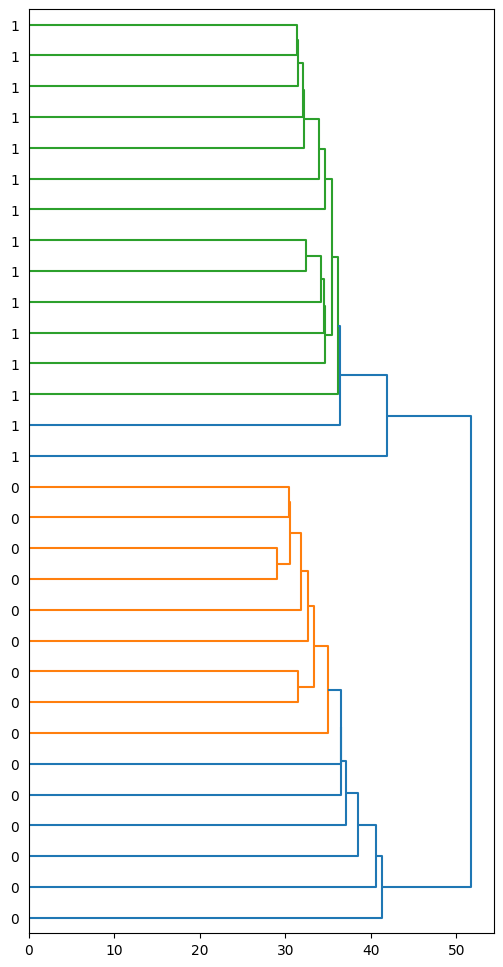

In [28]:
plt.figure(figsize=(6, 12))
den = hc.dendrogram(hc.linkage(tmp2, method='single'), orientation='right',labels=tmp)

eğer değerlerin kategorikse decision tree mantıklı, numerikse başka yol daha iyi olabilir
numerical encoding yaparken sıralamalarına dikkat et
logistic regression numaraları numara olarak okuyacak dikkat et ama aslında kategorik variable

np.unique.data3["occupation"]

hyperparameter tuning, space of parameters give me the best parameter knn svm için
model yazıyorsun sana en iyisini veriyor
what type of splitting 

random forestta depth of treeyi değiştirebiliyorsun
kategorik veri kısmında encoding kısmı sıkıntılı 
kategorik verileri al express them as binary variables and then use as a decision tree

In [ ]:
import pandas as pd 
df = pd.DataFrame({'labels': labels,'species':species})
print(df)
# dediğimizde hangi tür hangi labele giriyoru gösteren bir df elde ediyoruz
ct = pd.crosstab(df['labels', df['species']])

In [ ]:
ks = range(1,6)
inertias = []

for k in ks:
    model = KMeans(n_clusters = k)
    model.fit(samples)
    inertias.append(model.inertia_)

plt.plot(ks,inertias,'-o')
plt.xlabel('number of clusters,k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()